##*Twitter Suicidal-Intention Prediction with TFIDF*

By Storm Troopers

This notebook will show you how to build a Support Vector Classifier to predict if a tweet is suicidal-intended or not.

###**1. Imports** 

In [28]:
import pandas as pd
import numpy as np
import nltk
import re
import matplotlib.pyplot as plt
import seaborn as sns
import unicodedata
import pickle

from wordcloud import WordCloud, STOPWORDS

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from bs4 import BeautifulSoup

plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 70
plt.rcParams['axes.facecolor'] = 'white'

nltk.download("stopwords") 
stopwords = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


###**2. Retrieve and Inspect Dataset**

Let's download the dataset which is uploaded on my google drive. 

In [2]:
!gdown --id 16PXPwDjZCH45jC97LxZ8_9zAvi0pI7u6 

Downloading...
From: https://drive.google.com/uc?id=16PXPwDjZCH45jC97LxZ8_9zAvi0pI7u6
To: /content/twitter-suicidal_data.csv
3.63MB [00:00, 116MB/s]


We'll use `pandas` to parse the csv files.  

In [3]:
df = pd.read_csv('/content/twitter-suicidal_data.csv') 

Let's take a look at the first few rows of the table just to see what's in there.  

In [4]:
df.head() 

,tweet,intention
0,my life is meaningless i just want to end my l...,1
1,muttering i wanna die to myself daily for a fe...,1
2,work slave i really feel like my only purpose ...,1
3,i did something on the 2 of october i overdose...,1
4,i feel like no one cares i just want to die ma...,1


How many tweets do we have?


In [5]:
df.shape

(9119, 2)

Now, let's count the number of positive and negative Suicidal Intention in our dataset.

In [6]:
df['intention'].value_counts()

0    5121
1    3998
Name: intention, dtype: int64

Let's visualize it a little further.

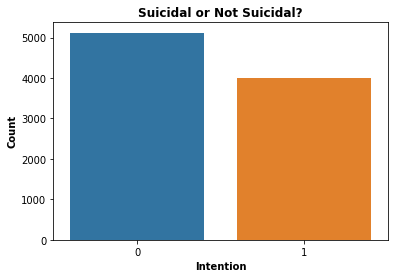

In [7]:
sns.countplot(x='intention', data=df)
plt.title('Suicidal or Not Suicidal?', fontweight='bold')
plt.xlabel('Intention', fontweight='bold')
plt.ylabel('Count', fontweight='bold');

Hmm. that's almost a balanced dataset, we'll work with this.

###**3. WordCloud**

Let's have an interesting visualiztion of the most used words in our corpus and seperate them based on the class intention.

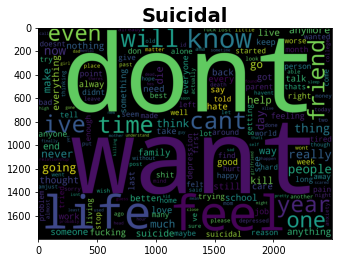

In [11]:
# Suicide == 1 in Corpus
subset = df[df.intention==1]
text = subset.tweet.values
cloud_suicidal = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          collocations=False,
                          width=2500,
                          height=1800
                         ).generate(" ".join(text))

plt.title("Suicidal",fontsize=20, fontweight='bold')
plt.imshow(cloud_suicidal);

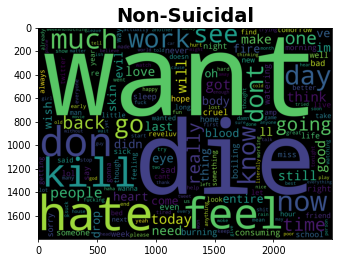

In [12]:
# Non-Suicidal == 0 in Corpus
subset = df[df.intention==0]
text = subset.tweet.values
cloud_non_suicidal = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          collocations=False,
                          width=2500,
                          height=1800
                         ).generate(" ".join(text))

plt.title("Non-Suicidal",fontsize=20, fontweight='bold')
plt.imshow(cloud_non_suicidal);

###**4. Data Preprocessing**

In [13]:
def clean_text(x):
  str(x).lower()  # Lower-case converstion
  re.sub(r'([a-z0-9+._-]+@[a-z0-9+_-]+)', '', x)  # Remove emails
  re.sub(r'(http|https|ftp|ssh)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', '', x) # Remove urls
  re.sub(r'\brt\b', '', x).strip() # Remove Re-tweets
  re.sub(r'[^\w ]+', '', x) # Remove Special Characters
  ' '.join(x.split()) # Remove Multiple spaces
  BeautifulSoup(x, 'lxml').get_text().strip() # Remove HTML tags
  ' '.join([t for t in x.split() if t not in stopwords]) # Remove stopwords
  unicodedata.normalize('NFKD', x).encode('ascii', 'ignore').decode('utf-8', 'ignore') # Remove Accented characters
  return x

df['tweet'] = df['tweet'].apply(lambda x: clean_text(x)) # Apply to tweet column in complete dataframe

Let's see how our final dataframe looks like.

In [14]:
df.head() 

,tweet,intention
0,my life is meaningless i just want to end my l...,1
1,muttering i wanna die to myself daily for a fe...,1
2,work slave i really feel like my only purpose ...,1
3,i did something on the 2 of october i overdose...,1
4,i feel like no one cares i just want to die ma...,1


###**5. TFIDF Vectorizer**

We'll use *Tfidf Vectorizer*. The TfidfVectorizer will tokenize documents, learn the vocabulary and inverse document frequency weightings, and allow you to encode new documents to a matrix of TF-IDF features.

In [26]:
tfidf = TfidfVectorizer(max_features=30000,    # max 30000 dimensional vector space
                        ngram_range=(1, 3),    #unigram, bigram and trigram
                        analyzer='word')       #tokenization is done word by word

pickle.dump(tfidf, open('tfidf-transform.pkl', 'wb'))

Let's set our model variables for training.

In [16]:
X = tfidf.fit_transform(df['tweet'])    
y = df['intention']

Now, let's split our dataframe into training and validation splits.

In [17]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

###**6. Linear SVC**

For our first classifier, we'll use LinearSVC from sklearn.

In [18]:
clf = LinearSVC(max_iter=50000)    #The maximum number of iterations for the quadratic programming problem to cycle through to optimize.
clf.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=50000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

Displaying the classification report and accuracy score for the first classifier.

In [33]:
# On Validation set
y_pred = clf.predict(X_val)
print(classification_report(y_val, y_pred))
print()
print("Accuracy: ", accuracy_score(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.94      0.93      1060
           1       0.92      0.90      0.91       764

    accuracy                           0.92      1824
   macro avg       0.92      0.92      0.92      1824
weighted avg       0.92      0.92      0.92      1824


Accuracy:  0.9226973684210527


Confusion matrix for first classifier.

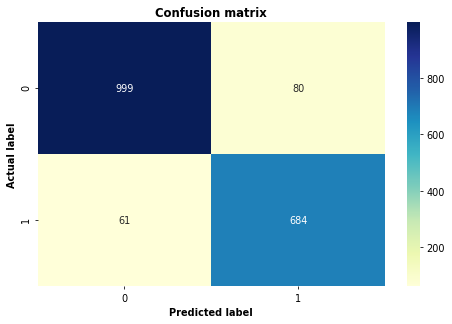

In [34]:
y_pred = clf.predict(X_val)  
cm = confusion_matrix(y_pred, y_val) 
fig, ax = plt.subplots(figsize=(8,5))
sns.heatmap(cm, annot = True, cmap = 'YlGnBu', fmt='g'); 
plt.title('Confusion matrix', fontweight='bold')
plt.ylabel('Actual label', fontweight='bold')
plt.xlabel('Predicted label', fontweight='bold');

###**7. SVC**

For our second classifier, we'll use SVC from sklearn.

In [20]:
clf2 = SVC(max_iter=50000)    #The maximum number of iterations for the quadratic programming problem to cycle through to optimize.
clf2.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=50000, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

Displaying the classification report for the second classifier.

In [37]:
# On Validation set
y_pred2 = clf2.predict(X_val)
print(classification_report(y_val, y_pred2))
print()
print("Accuracy: ", accuracy_score(y_val, y_pred2))

              precision    recall  f1-score   support

           0       0.91      0.97      0.94      1060
           1       0.96      0.87      0.91       764

    accuracy                           0.93      1824
   macro avg       0.93      0.92      0.93      1824
weighted avg       0.93      0.93      0.93      1824


Accuracy:  0.9287280701754386


Confusion matrix for second classifier.

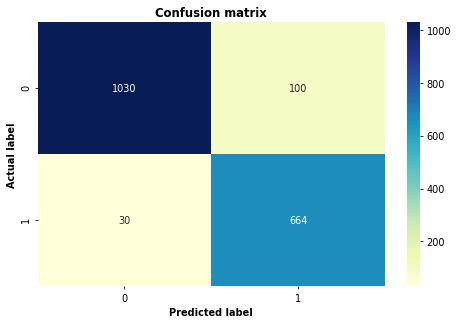

In [36]:
y_pred2 = clf2.predict(X_val)  
cm = confusion_matrix(y_pred2, y_val) 
fig, ax = plt.subplots(figsize=(8,5))
sns.heatmap(cm, annot = True, cmap = 'YlGnBu', fmt='g'); 
plt.title('Confusion matrix', fontweight='bold')
plt.ylabel('Actual label', fontweight='bold')
plt.xlabel('Predicted label', fontweight='bold');

###**8. Predictions**

Now since we have trained our model, we'll use both our models for predicting some of our own intentions. Let's try predicting a suicidal intention text.

In [22]:
x = 'no one cares about me. I will die alone. i feel depressed'
x = clean_text(x)
vec = tfidf.transform([x])
print(clf.predict(vec), clf2.predict(vec))     # First classifier and Second Classifier 

[1] [1]


Let's see the predictions for a non-suicidal intention text.

In [23]:
x = 'Today I am so happy, thanks a lot for making my day special'
x = clean_text(x)
vec = tfidf.transform([x])
print(clf.predict(vec), clf2.predict(vec))     # First classifier and Second Classifier

[0] [0]


###**9. Model Saving**

In [24]:
filename = 'twitter-suicidal-LinearSVC.pkl'
pickle.dump(clf, open(filename, 'wb')) 

In [25]:
filename = 'twitter-suicidal-SVC.pkl'
pickle.dump(clf2, open(filename, 'wb')) 